In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nengo
import scipy
import time
import itertools
from NEF_RL import *
palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='paper', style='white', font="cmr10", font_scale=1.2)
plt.rcParams['axes.formatter.use_mathtext'] = True

## All SID

In [2]:
human = pd.read_pickle("data/carrabin.pkl")
bayes_n = pd.read_pickle("data/bayes_n_carrabin_feb12_dynamics.pkl")
rln = pd.read_pickle("data/RL_n2_carrabin_feb12_dynamics.pkl")
nef_rl = pd.read_pickle("data/NEF_RL_carrabin_feb17_dynamics.pkl")
dfs = [human, bayes_n, rln, nef_rl]
combined = pd.concat(dfs, ignore_index=True)
combined['alpha'] = None

In [3]:
for sid in human['sid'].unique():
    print(sid)
    subdata = combined.query("sid==@sid")
    for i, row in subdata.iterrows():
        mt = row['type']
        sid = row['sid']
        trial = row['trial']
        stage = row['stage']
        response = row['response']
        if stage>1:
            stage_old = stage - 1
            # print(mt, sid, trial, stage, stage_old)
            response_old = subdata.query("type==@mt & trial==@trial & stage==@stage_old")['response'].to_numpy()[0]
            delta = response_old - response
            color = human.query("sid==@sid & trial==@trial & stage==@stage")['color'].to_numpy()[0]
            prediction_error = color - response_old
            alpha = np.abs(delta / prediction_error) if prediction_error!=0 else 0
            combined.at[i, 'alpha'] = alpha
combined.to_pickle("data/alphas_RLn_NEF_RL_neurons.pkl")

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


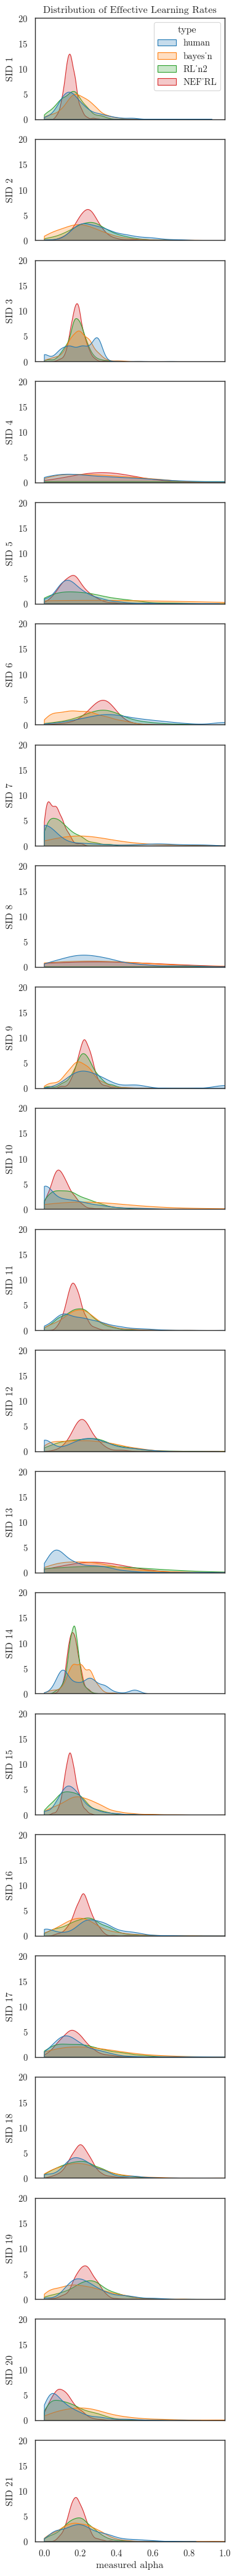

In [4]:
sids = human['sid'].unique()
fig, axes = plt.subplots(nrows=len(sids), ncols=1, figsize=(4, 2*len(sids)), sharex=True)
for s, sid in enumerate(sids):
    sns.kdeplot(combined.query("sid==@sid"), x='alpha', hue='type', ax=axes[s],
                clip=[0, 1], palette=palette[:4], fill=True, common_norm=False)
    axes[s].set(ylabel=f"SID {sid}", ylim=[0, 20])
    # axes[s].axvline(target_alphas[s], color='k', ls="--")
    if s>0: axes[s].get_legend().remove()
axes[0].set(title='Distribution of Effective Learning Rates')
axes[-1].set(xlabel='measured alpha', xlim=[-0.05, 1])
plt.tight_layout()
fig.savefig("plots/alpha_distributions_all_sids.jpg", dpi=600)

### Three panel replot

In [14]:
def three_plotz(sids):
    dfs = []
    for sid in sids:
        dfs.append(pd.read_pickle("data/carrabin.pkl").query("sid==@sid"))
        dfs.append(pd.read_pickle(f"data/bayes_n_carrabin_feb12_dynamics.pkl").query("sid==@sid"))
        dfs.append(pd.read_pickle(f"data/RL_n2_carrabin_feb12_dynamics.pkl").query("sid==@sid"))
        dfs.append(pd.read_pickle(f"data/NEF_RL_carrabin_feb17_dynamics.pkl").query("sid==@sid"))
    combined = pd.concat(dfs, ignore_index=True)
    combined['alpha'] = None
    for i, row in combined.iterrows():
        mt = row['type']
        trial = row['trial']
        stage = row['stage']
        sid = row['sid']
        response = row['response']
        if stage>1:
            stage_old = stage - 1
            response_old = combined.query("type==@mt & sid==@sid & trial==@trial & stage==@stage_old")['response'].to_numpy()[0]
            delta = response_old - response
            color = human.query("sid==@sid & trial==@trial & stage==@stage")['color'].to_numpy()[0]
            prediction_error = color - response_old
            alpha = np.abs(delta / prediction_error) if prediction_error!=0 else 0
            combined.at[i, 'alpha'] = alpha

    types = combined['type'].unique()
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(4, 6), sharex=True, sharey=True)
    for s, sid in enumerate(sids):
        sns.kdeplot(combined.query("sid==@sid"), x='alpha', hue='type', ax=axes[s], clip=[0, 1], palette=palette[:4], fill=True, common_norm=False, hue_order=types)
        axes[s].set(ylabel=f"SID {sid}", ylim=[0, 7])
        if s>0: axes[s].get_legend().remove()
    axes[0].set(title='Distribution of Behavioral Learning Rates')
    axes[-1].set(xlabel='Learning Rate', xlim=[-0.05, 1])
    plt.tight_layout()
    fig.savefig("plots/three_behavioral_learning_rates.jpg", dpi=600)

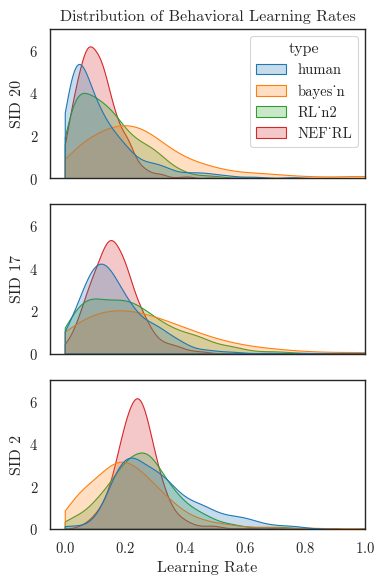

In [15]:
three_plotz([20,17,2])